## Hospital readmissions data analysis and recommendations for reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise overview

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
%matplotlib inline

In [2]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary analysis

In [3]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[(hospital_read_df['Number of Discharges'] != 'Not Available')]
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort('Number of Discharges')

/Library/Python/2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


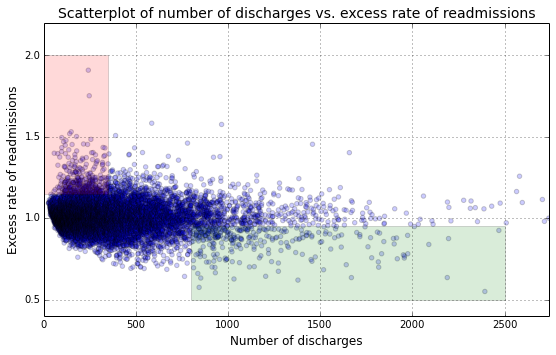

In [4]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary report

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****

## Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

The authors make a claim about the excess readmission ratio for two groups of hospitals: those with a number of discharges greater than 1000 and those with a number of discharges less than 100. Then, they argue that hospitals with a capacity less than 300 should upgrade their resource allocation to perform as well as large hospitals. This claim needs to be tested. As the initial justfication is based off of the 100-1000 split, I'm analyzing that. First we should visualize the data from those two categories.

In [37]:
#Get the data for large and small hospitals
lrg = clean_hospital_read_df['Excess Readmission Ratio'][(clean_hospital_read_df['Number of Discharges'] > 1000)
                                                          & (clean_hospital_read_df['Excess Readmission Ratio'].notnull())]

sml = clean_hospital_read_df['Excess Readmission Ratio'][(clean_hospital_read_df['Number of Discharges'] < 100)
                                                          & (clean_hospital_read_df['Excess Readmission Ratio'].notnull())]



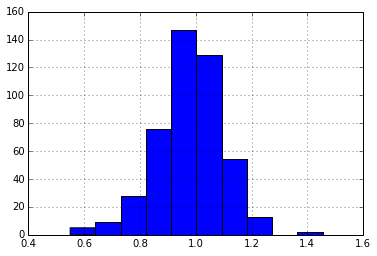

In [44]:
#Histogram the large hospital excess readmission ratios
lrg.hist()

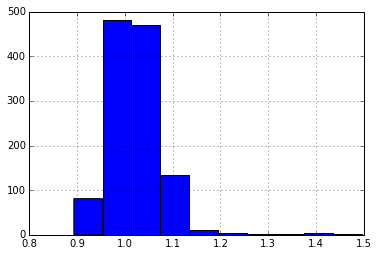

In [45]:
#Histogram the small hospital excess readmission ratios
sml.hist()

([<matplotlib.axis.XTick at 0x10f428b50>,
 <a list of 2 Text xticklabel objects>)

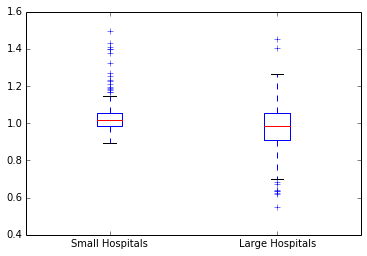

In [46]:
d = plt.boxplot([list(sml), list(lrg)])
plt.xticks([1, 2], ['Small Hospitals', 'Large Hospitals'])


This data set represents more than 10% of the population of US hospitals defined as large and small. Therefore, we cannot use the Central Limit Theorem to estimate standard error and do a hypothesis test. We need to use simulation methods. I am bootstrapping a 99% confidence interval for the difference in the median excess readmission ratio between large hospitals and small hospitals. To accomplish this, I am resampling the distributions of the two hospital categories with replacement and taking median 10,000 times. I am selecting the median, as these distributions are somewhat skewed.

In [48]:
lrg.median()

0.9864

In [49]:
sml.median()

1.01775

In [62]:
r = 10000
lrg_boot = [lrg[lrg.index[np.random.randint(0,len(y_lg),len(y_lg))]].median() for i in range(r)]
sml_boot = [sml[sml.index[np.random.randint(0,len(y_sm),len(y_sm))]].median() for i in range(r)]

In [64]:
np.median(lrg_boot)

0.98640000000000005

In [65]:
np.percentile(lrg_boot, [2.5, 97.5])

[0.97719999999999996, 0.99619999999999997]

In [66]:
np.median(sml_boot)

1.0177499999999999

In [67]:
np.percentile(sml_boot, [2.5, 97.5])

[1.0137, 1.0209999999999999]

In [70]:
1 - (np.median(lrg_boot)/np.median(sml_boot))

0.030803242446573176

In [68]:
diff = np.array(lrg_boot) - np.array(sml_boot)
prct = np.percentile(diff, [0.5, 99.5])
prct

[-0.044500250000000095, -0.016299999999999981]

The 99% confidence interval of the difference in medians between large hospitals does not contain zero. Therefore, the probability that the observed data came from a distribution where that difference is zero is less than 1%. We can reject the null hypothesis that there is no difference between small and large hospitals. Thus, we can tentatively accept the authors' claim that small facilities have higher excess readmission ratios than larger facilities.

The authors' proposed solution, however, discusses what should be done with hospitals with less than 300 readmissions, whereas their statistical claims concern hospitals with less than 100 readmissions. As such, the proposed solution is outside the scope of the current analysis. 

Additionally. the difference in excess readmission ratios between the median small and median large hospital is ~3.1%. It is possible that the cost of expanding smaller facilities or merging them with other instiutions exceeds the benefit in increased care. Indeed, the process of changing facilities may negatively affect readmission rates, wiping out the benefit of increased capacity. In this case, I would suggest a deeper analysis into the factors that drive differences in the excess readmission ratio before proceeding with any plan to consolidate or expand institutions.